<a href="https://colab.research.google.com/github/mukamal/predicting_gme_stock_price/blob/main/Predicting_GME_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Predicting Gamestop Stock Price using Reddit Sentiment Analysis

A few months ago, some people got together on a subreddit named “WallStreetBets“- a group already infamous for manipulating securities and using harsh language. The people came up with a plan to artificially raise the stock price of GameStop. Which lead to quite an impact and Gamestop's stock price skyrocketed from 20 USD to more than 400 USD. The stock price was mainly rising due to coordinated groups of retail investors on Reddit who planned and decided to invest in it.

For this project the dataset, Subreddit “WallStreetBets” Posts, available on Kaggle, was used that comprised a total of 31 thousand posts dating from 28th January,2021 till 21st April, 2021.


#Importing needed packages

In [28]:
pip install yfinance

In [29]:
pip install yahoofinancials


In [30]:
import re
import yfinance as yf
from yahoofinancials import YahooFinancials
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
import nltk
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.decomposition import TruncatedSVD,PCA

from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('vader_lexicon')
from wordcloud import WordCloud,STOPWORDS
import spacy as sp

nlps = sp.load('en')
import numpy as np

import matplotlib.pyplot as plt

plt.rc('figure',figsize=(17,13))
import seaborn as sns
sns.set_style('darkgrid')

from plotly.subplots import make_subplots

import plotly.graph_objs as go

import plotly.express as ex
import matplotlib.dates as mdates
from itertools import islice
from collections import Counter
from nltk.corpus import stopwords




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


#Importing Dataset

In [31]:
#Host your data in your Google drive and then mount to your Google drive. 
#You will be given an authorization code to finish the process

from  google.colab import drive     
drive.mount('/content/drive')


# read in the training data. The dataset includes columns: title, body
import pandas as pd
df =pd.read_csv("/content/drive/My Drive/TM/reddit_wsb.csv")
df = df[pd.to_datetime(df.timestamp).dt.year>=2021]
df.head(3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35


#EDA

In [32]:
# What is the average length of the title
df1 = df.replace(np.nan, '', regex=True)

df1['len_title']=df1['title'].apply(lambda x : len(x.split(' ')))
df1['len_body']=df1['body'].apply(lambda x : len(x.split(' ')))
df1.describe()

,score,comms_num,created,len_title,len_body
count,45422.000000,45422.000000,4.542200e+04,45422.000000,45422.000000
mean,1454.042909,237.456761,1.613026e+09,11.004954,85.546607
std,8449.893894,2571.269169,1.629286e+06,8.715191,253.700492
min,0.000000,0.000000,1.611818e+09,1.000000,1.000000
25%,1.000000,2.000000,1.611881e+09,5.000000,1.000000
50%,31.000000,13.000000,1.612313e+09,9.000000,1.000000
75%,190.000000,51.000000,1.613758e+09,14.000000,54.000000
max,348241.000000,93268.000000,1.619026e+09,66.000000,6301.000000


#Text Preprocessing
Before performing exploratory data analysis, some essential text preprocessing, like removing twitter handles,urls, special characters, extra spaces or changing all text to lower case was performed using RegEx.

In [33]:
#Text Preprocessing
#Remove NAs
title_data = df[['title','timestamp']].copy()
body_data = df[['body','timestamp']].copy()
body_data = body_data.dropna()
title_data = title_data.dropna()


#lower_case
title_data.title =title_data.title.str.lower()
body_data.body =body_data.body.str.lower()


#Remove handlers
title_data.title = title_data.title.apply(lambda x:re.sub('@[^\s]+','',x))
body_data.body   = body_data.body.apply(lambda x:re.sub('@[^\s]+','',x))


# Remove URLS
title_data.title = title_data.title.apply(lambda x:re.sub(r"http\S+", "", x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r"http\S+", "", x))


# Remove all the special characters
title_data.title = title_data.title.apply(lambda x:' '.join(re.findall(r'\w+', x)))
body_data.body   = body_data.body.apply(lambda x:' '.join(re.findall(r'\w+', x)))


#remove all single characters
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', ' ', x))

# Substituting multiple spaces with single space
title_data.title = title_data.title.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))
body_data.body   = body_data.body.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))




In [34]:
#Add date column

title_data["date"] = pd.to_datetime(title_data.timestamp).dt.date
body_data["date"] = pd.to_datetime(body_data.timestamp).dt.date
title_data.head(3)

,title,timestamp,date
0,it not about the money it about sending message,2021-01-28 21:37:41,2021-01-28
1,math professor scott steiner says the numbers ...,2021-01-28 21:32:10,2021-01-28
2,exit the system,2021-01-28 21:30:35,2021-01-28



Below is the list of top 20 words that were most used in the group, during the given timeframe.
As can be seen below “GME” (stock ticker of Gamestop) has the highest number of occurrences, followed by “buy”/”bought”, “hold”, “stock”, “short”, “sell”.


<BarContainer object of 20 artists>

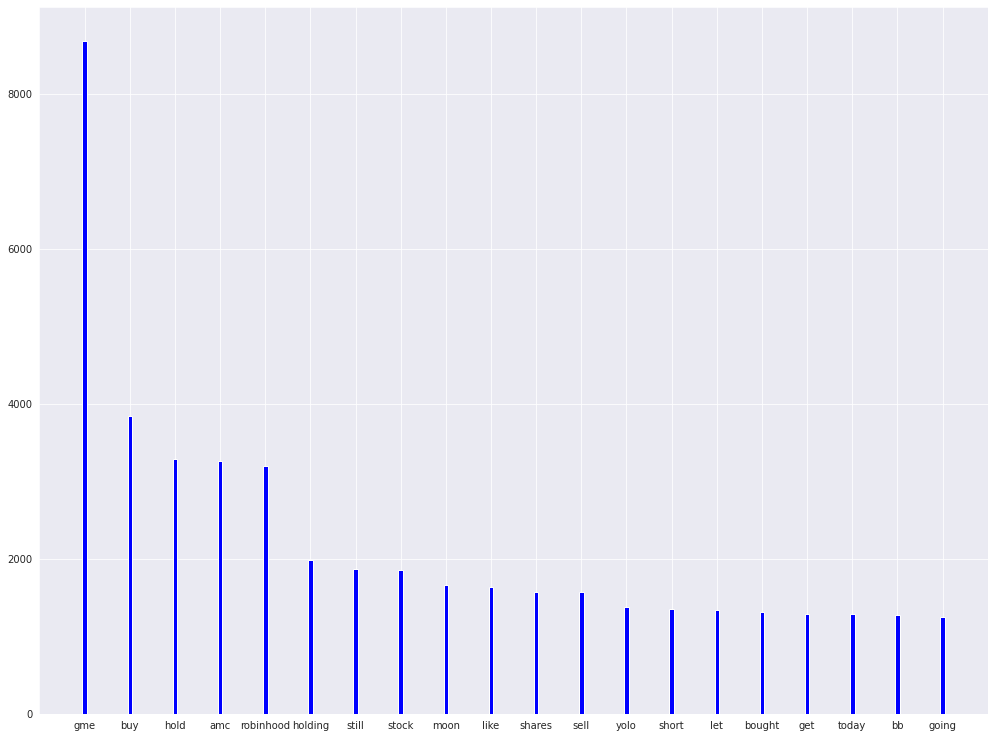

In [35]:
stop_words = set(stopwords.words('english'))  

title_data['title2'] = [' '.join([w for w in x.lower().split() if w not in stop_words]) for x in title_data['title'].tolist()]
top_words=Counter(" ".join(title_data["title2"]).split()).most_common(20)
my_dict = dict(top_words)

plt.bar(my_dict.keys(), my_dict.values(), width=.1, color='b')


Below is the daily number of posts that were posted in the group. As can be seen, there is a spike in the number of posts on the 29th of January, 2021. There were a total of 16 thousand posts posted on that day as opposed to an average number of posts of 500. While it seemed to be erroneous initially but when investigated in turned out to be exact day when stock price of Gamestop was at an all time high.



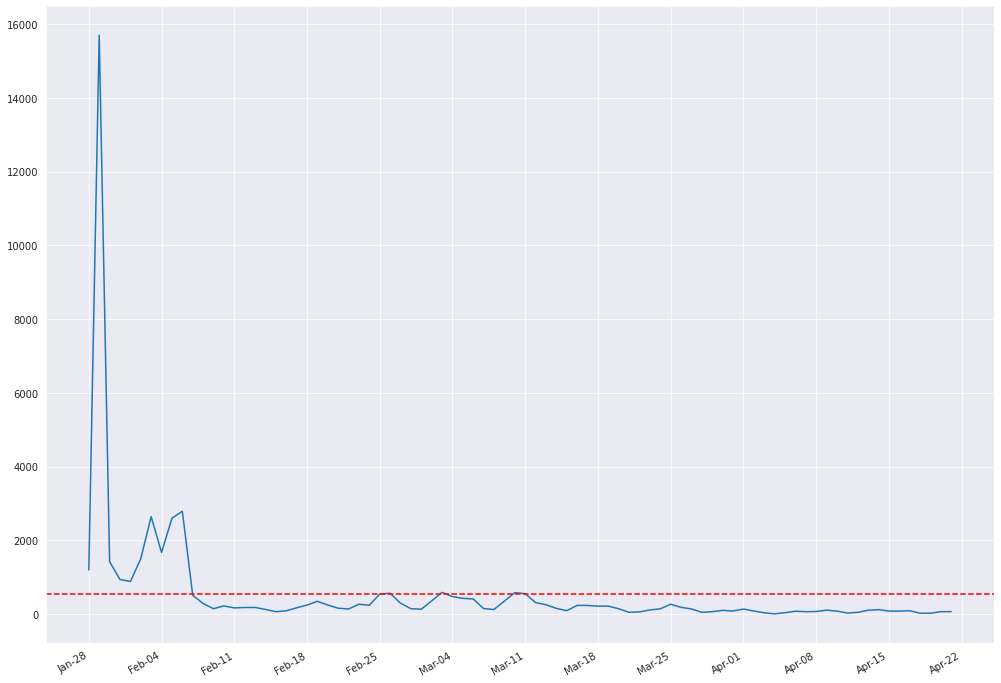

In [36]:
#Daily number of posts


b_date_count = title_data.groupby(by='date').count().reset_index()
b_date_count = b_date_count.rename(columns={'title':'Posts_Per_Day'})
b_date_count.head(10)

b_date_count.Posts_Per_Day.astype(int)

# print(b_date_count.head(5))
# print(b_date_count['Posts_Per_Day'].mean())


ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
plt.plot(b_date_count.date, b_date_count.Posts_Per_Day)
plt.gcf().autofmt_xdate()
plt.axhline(y = b_date_count['Posts_Per_Day'].mean(), color = 'r', linestyle = 'dashed', label = "red line")    

plt.show()

#Gamestop Stock Price
Gamestop Stock Price dataset was downloaded from Yahoo Finance. The time period was from 28th January,2021 till 21st April, 2021 so as to compare with the available dataset from reddit. The interval of the dataset was “daily”, which mostly comprised of the daily opening and closing price of the Gamestop stock price.

Following is the snippet of the Gamestop Stock Price dataset.


[*********************100%***********************]  1 of 1 completed


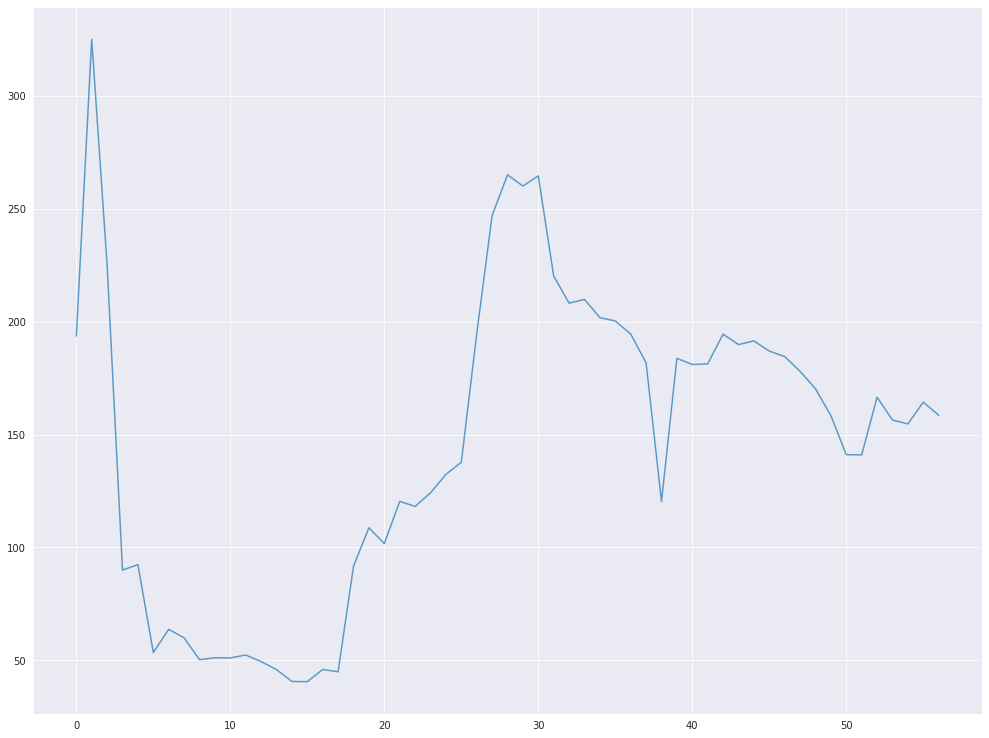

In [37]:
data=['GME']
yahoo_financials = YahooFinancials(data)
data = yahoo_financials.get_historical_price_data(start_date='2021-01-28', 
                                                  end_date='2021-04-21', 
                                                  time_interval="daily")


data_stock = yf.download("GME", start="2021-01-28", end="2021-04-21",group_by="ticker")

plt.plot(np.arange(len(data_stock)), data_stock.Close, alpha=0.7, label='Close' )

In [38]:
title_data_gme=title_data[title_data['title'].str.contains("gme|gamestop")].reset_index()
#title_data_gme.drop(columns=['title2'],inplace=True)
title_data_gme.head()

,index,title,timestamp,date,title2
0,1,math professor scott steiner says the numbers ...,2021-01-28 21:32:10,2021-01-28,math professor scott steiner says numbers spel...
1,3,new sec filing for gme can someone less retard...,2021-01-28 21:28:57,2021-01-28,new sec filing gme someone less retarded pleas...
2,4,not to distract from gme just thought our amc ...,2021-01-28 21:26:56,2021-01-28,distract gme thought amc brothers aware
3,8,currently holding amc and nok is it retarded t...,2021-01-28 21:19:16,2021-01-28,currently holding amc nok retarded think move ...
4,11,gme premarket musk approved,2021-01-28 21:17:28,2021-01-28,gme premarket musk approved


In order to perform sentiment analysis “vader”, package available in NLTK, was used. “Vader” is a lexicon and rule-based sentiment analysis tool that is specifically built for sentiments expressed in social media.

In [39]:
sia = SIA()

title_data_gme['sentiments']           = title_data_gme['title'].apply(lambda x: sia.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))
title_data_gme['Positive Sentiment']   = title_data_gme['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
title_data_gme['Neutral Sentiment']    = title_data_gme['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
title_data_gme['Negative Sentiment']   = title_data_gme['sentiments'].apply(lambda x: x['neg']+1*(10**-6))
title_data_gme['Compound Sentiment']   = title_data_gme['sentiments'].apply(lambda x: x['compound']+1*(10**-6))

title_data_gme.drop(columns=['sentiments'],inplace=True)
title_data_gme.head()

,index,title,timestamp,date,title2,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment
0,1,math professor scott steiner says the numbers ...,2021-01-28 21:32:10,2021-01-28,math professor scott steiner says numbers spel...,0.000001,0.728001,0.272001,-0.624899
1,3,new sec filing for gme can someone less retard...,2021-01-28 21:28:57,2021-01-28,new sec filing gme someone less retarded pleas...,0.138001,0.658001,0.204001,-0.274799
2,4,not to distract from gme just thought our amc ...,2021-01-28 21:26:56,2021-01-28,distract gme thought amc brothers aware,0.119001,0.881001,0.000001,0.223501
3,8,currently holding amc and nok is it retarded t...,2021-01-28 21:19:16,2021-01-28,currently holding amc nok retarded think move ...,0.000001,0.812001,0.188001,-0.571899
4,11,gme premarket musk approved,2021-01-28 21:17:28,2021-01-28,gme premarket musk approved,0.483001,0.517001,0.000001,0.421501


#Pattern between number of posts and price shoot

Once we had the daily stock price’s dataset for gamestop, the reddit posts dataset was grouped together into daily posts. And then the daily sentiment analysis was performed and plotted against daily stock price, after normalization and transformation.

As you can see, there seems to be a correlation between the 2 graphs. But there is a caveat…. 


In [40]:
norm_price=2*(data_stock["Close"]/max(data_stock["Close"]))-.5
norm_price=data_stock["Close"]/max(data_stock["Close"])/3


#norm_price=np.log(data_stock["Close"])/max(np.log(data_stock["Close"]))-.8

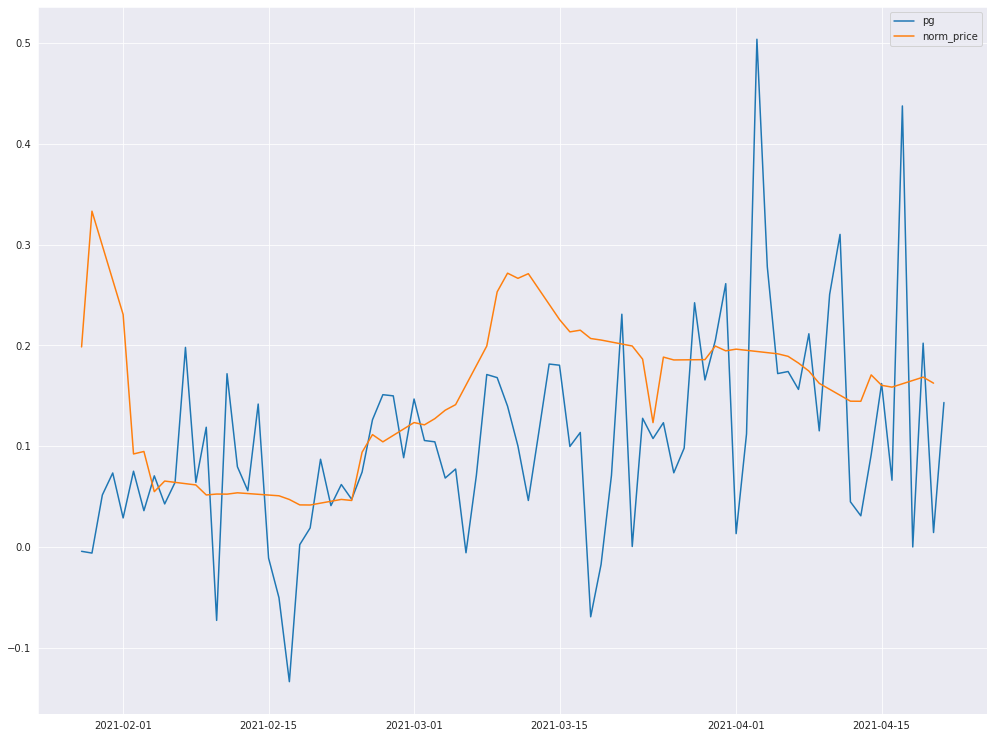

In [41]:
data_compare=title_data_gme


pg=title_data_gme.groupby('date')['Compound Sentiment'].mean().reset_index()
pg_gme=data_compare.groupby('date')['Compound Sentiment'].mean().reset_index()


#plt.plot(pg.date, pg['Compound Sentiment'])

plt.plot(pg_gme.date, pg_gme['Compound Sentiment'])
plt.plot(norm_price)

plt.legend(["pg","norm_price"])

#Caveat
Following is a post taken from the reddist dataset. It may seem that the given post is sentimentally negative and, infact, the model recognises it as a negative sentiment. But the fact of the matter is that this post indicates a positive trend in the stock price of gamestop. Hence it was concluded that “vader” is not a good sentiment analysis tool for our problem. A model that was trained on a financial dataset might have been useful and relevant instead.


In [42]:
title_data_gme['title'][0]

'math professor scott steiner says the numbers spell disaster for gamestop shorts'

Model doesnt understand the financial situation

#Re-labeling Dataset
Given the above problem, an attempt was made to label dataset according to the daily trend in the stock price of Gamestop. The daily trend was computed by the difference between the daily closing and opening price of the stock.

Following is the snippet of the relabeled dataset,  where “Trend” value of “0” means the price of the stock dropped on the given day, while “Trend” value of 1 means that stock price increased on the given day. 


In [43]:
data_stock.loc[data_stock['Close'] -data_stock['Open']>=0, 'Trend'] = 1
data_stock.loc[data_stock['Close'] -data_stock['Open']<0, 'Trend'] = 0

#df.loc[df['A'] > df['B'], 'C'] = 1
#df.loc[df['A'] < df['B'], 'C'] = -1
#data_stock["Close"] - data_stock["Open"]
data_stock.head()

,Open,High,Low,Close,Adj Close,Volume,Trend
Date,,,,,,,
2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800,0.0
2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50566100,0.0
2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200,0.0
2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100,0.0
2021-02-03,112.010002,113.400002,85.250000,92.410004,92.410004,42698500,0.0


In [44]:
title_data_gme.head()

,index,title,timestamp,date,title2,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment
0,1,math professor scott steiner says the numbers ...,2021-01-28 21:32:10,2021-01-28,math professor scott steiner says numbers spel...,0.000001,0.728001,0.272001,-0.624899
1,3,new sec filing for gme can someone less retard...,2021-01-28 21:28:57,2021-01-28,new sec filing gme someone less retarded pleas...,0.138001,0.658001,0.204001,-0.274799
2,4,not to distract from gme just thought our amc ...,2021-01-28 21:26:56,2021-01-28,distract gme thought amc brothers aware,0.119001,0.881001,0.000001,0.223501
3,8,currently holding amc and nok is it retarded t...,2021-01-28 21:19:16,2021-01-28,currently holding amc nok retarded think move ...,0.000001,0.812001,0.188001,-0.571899
4,11,gme premarket musk approved,2021-01-28 21:17:28,2021-01-28,gme premarket musk approved,0.483001,0.517001,0.000001,0.421501


In [45]:
# concatenate the string
df=title_data_gme
df['title'] = df.groupby(['date'])['title'].transform(lambda x : ' '.join(x))
  

 

In [46]:
# drop duplicate data
df = df.drop_duplicates(subset='title', keep="first")
df.head()

,index,title,timestamp,date,title2,Positive Sentiment,Neutral Sentiment,Negative Sentiment,Compound Sentiment
0,1,math professor scott steiner says the numbers ...,2021-01-28 21:32:10,2021-01-28,math professor scott steiner says numbers spel...,0.000001,0.728001,0.272001,-0.624899
272,1197,current data on gme short positions whats this...,2021-01-29 01:02:55,2021-01-29,current data gme short positions,0.000001,1.000001,0.000001,0.000001
3326,16582,degiro only allowing limit orders for gme and ...,2021-01-30 01:13:46,2021-01-30,degiro allowing limit orders gme amc eu bois l...,0.000001,1.000001,0.000001,0.000001
3562,17619,what can do to support gme as someone who neve...,2021-01-31 01:46:50,2021-01-31,support gme someone never done stock,0.197001,0.803001,0.000001,0.401901
3820,18575,although they write that melvin is down 53 the...,2021-02-01 02:15:51,2021-02-01,although write melvin 53 continue say fine eve...,0.036001,0.865001,0.099001,-0.476699


In [47]:
# What is the average length of the title
#df1 = df.replace(np.nan, '', regex=True)

#df1['len_title']=df1['title'].apply(lambda x : len(x.split(' ')))
df["gme"]=df.title.str.count("gme|gamestop")

df["buy"]=df.title.str.count("buy|bought|get")
df["hold"]=df.title.str.count("hold|holding")
df["sell"]=df.title.str.count("sell|short")


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [48]:
#Todo

#add neutral cat in price trend using S&P
# offset data so that sentiment is predicting
#off days of the market
#day ends at 5pm


In [49]:
df_p=data_stock.reset_index()
df_p.rename(columns = {'Date':'date'}, inplace = True)

df_p.head()

,date,Open,High,Low,Close,Adj Close,Volume,Trend
0,2021-01-28,265.000000,483.000000,112.250000,193.600006,193.600006,58815800,0.0
1,2021-01-29,379.709991,413.980011,250.000000,325.000000,325.000000,50566100,0.0
2,2021-02-01,316.559998,322.000000,212.000000,225.000000,225.000000,37382200,0.0
3,2021-02-02,140.759995,158.000000,74.220001,90.000000,90.000000,78183100,0.0
4,2021-02-03,112.010002,113.400002,85.250000,92.410004,92.410004,42698500,0.0


In [50]:
df_p.shape

(57, 8)

In [51]:


a=df[["title","date","gme","buy","hold","sell"]]
a["buySell"]=a["buy"]/a["sell"]
b=df_p[["Trend","date"]]
b["date"]=pd.to_datetime(b["date"]).dt.date

data_bert = b.merge(a, how = 'inner', on ='date')



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [52]:
data_bert.head()

,Trend,date,title,gme,buy,hold,sell,buySell
0,0.0,2021-01-28,math professor scott steiner says the numbers ...,279,103,38,31,3.322581
1,0.0,2021-01-29,current data on gme short positions whats this...,3256,1458,507,391,3.728900
2,0.0,2021-02-01,although they write that melvin is down 53 the...,250,46,36,49,0.938776
3,0.0,2021-02-02,if you re buying silver comment here not for j...,340,97,81,74,1.310811
4,0.0,2021-02-03,loss porn im not fucking selling gme omg games...,585,182,138,109,1.669725


In [53]:
#data_bert.drop(data_bert.index[[0,1]])
data_bert.head()

,Trend,date,title,gme,buy,hold,sell,buySell
0,0.0,2021-01-28,math professor scott steiner says the numbers ...,279,103,38,31,3.322581
1,0.0,2021-01-29,current data on gme short positions whats this...,3256,1458,507,391,3.728900
2,0.0,2021-02-01,although they write that melvin is down 53 the...,250,46,36,49,0.938776
3,0.0,2021-02-02,if you re buying silver comment here not for j...,340,97,81,74,1.310811
4,0.0,2021-02-03,loss porn im not fucking selling gme omg games...,585,182,138,109,1.669725



An attempt was also made to find a pattern between the number of times the word “sell” was used, daily and the trend of the stock price. While there was no clear trend with between the trend and number of times “sell” was used, there appeared to be a cyclical trend in the count of “sell”



In [54]:
#plot_df['sell'].plot(kind='bar', color=[colors[i] for i in plot_df['Trend']])

In [55]:
dff = data_bert.sample(frac=1)
#train_size = int(0.01 * len(dff))
#df_train = dff[:train_size]
#df_test = dff[train_size:]
df_train = dff[:50]
df_test = dff[-7:]
print(df_train.shape)
print(df_test.shape)
X_train, y_train = df_train['title'].values, df_train['Trend'].values
X_test, y_test = df_test['title'].values, df_test['Trend'].values

(50, 8)
(7, 8)


In [56]:
data_bert[-1:].shape

(1, 8)

In [57]:
import numpy as np
unique, counts = np.unique(y_train, return_counts=True)
print(np.asarray((unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print(np.asarray((unique, counts)))

[[ 0.  1.]
 [34. 16.]]
[[0. 1.]
 [2. 5.]]


#BERT

In [60]:
# install BERT sklearn wrapper written by charles9n
# check out the github page for fine tuning options and usage
# https://github.com/charles9n/bert-sklearn

!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .

Cloning into 'bert-sklearn'...
remote: Enumerating objects: 259, done.
remote: Total 259 (delta 0), reused 0 (delta 0), pack-reused 259
Receiving objects: 100% (259/259), 516.15 KiB | 8.75 MiB/s, done.
Resolving deltas: 100% (131/131), done.
Processing /content/bert-sklearn
     |████████████████████████████████| 133kB 3.8MB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 7.5MB 8.9MB/s 
  Created wheel for bert-sklearn: filename=bert_sklearn-0.3.1-cp37-none-any.whl size=54235 sha256=34de7ae1fd5bd0492ea7c45acf52391043b41abca4a7ab048b2a5a6f7081cbcc
  Stored in directory: /root/.cache/pip/wheels/61/95/c6/5790aae8fb377f5ff356dbe58205aab28858595d6bff8197d0
Successfully built bert-sklearn
ERROR: botocore 1.20.76 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [61]:
# fine tune a BERT base uncased model
# since this wrapper has included vectorization using word embedding, no need to vectorize like in LinearSVC
# first the pre-trained BERT model will be loaded in
# then the training starts. 90% examples will be used as training examples and the other 10% as validation (parameter tuning)
# default setting is 3 epoch. Each epoch takes in some training data
from bert_sklearn import BertClassifier
model = BertClassifier()         # text/text pair classification
print(model)
model.fit(X_train, y_train)

Building sklearn text classifier...
BertClassifier(bert_config_json=None, bert_model='bert-base-uncased',
               bert_vocab=None, do_lower_case=None, epochs=3, eval_batch_size=8,
               fp16=False, from_tf=False, gradient_accumulation_steps=1,
               ignore_label=None, label_list=None, learning_rate=2e-05,
               local_rank=-1, logfile='bert_sklearn.log', loss_scale=0,
               max_seq_length=128, num_mlp_hiddens=500, num_mlp_layers=0,
               random_state=42, restore_file=None, train_batch_size=32,
               use_cuda=True, validation_fraction=0.1, warmup_proportion=0.1)


100%|██████████| 231508/231508 [00:00<00:00, 2924867.10B/s]


Loading bert-base-uncased model...


100%|██████████| 433/433 [00:00<00:00, 86019.69B/s]


Defaulting to linear classifier/regressor
Loading Pytorch checkpoint

train data size: 45, validation data size: 5



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.



/usr/local/lib/python3.7/dist-packages/bert_sklearn/model/pytorch_pretrained/optimization.py:275: UserWarning:

This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:1005.)





Epoch 1, Train loss: 0.5755, Val loss: 0.9993, Val accy: 40.00%





Epoch 2, Train loss: 0.6005, Val loss: 0.9432, Val accy: 40.00%





Epoch 3, Train loss: 0.5551, Val loss: 0.9119, Val accy: 40.00%



BertClassifier(bert_config_json=None, bert_model='bert-base-uncased',
               bert_vocab=None, do_lower_case=True, epochs=3, eval_batch_size=8,
               fp16=False, from_tf=False, gradient_accumulation_steps=1,
               ignore_label=None, label_list=array([0., 1.]),
               learning_rate=2e-05, local_rank=-1, logfile='bert_sklearn.log',
               loss_scale=0, max_seq_length=128, num_mlp_hiddens=500,
               num_mlp_layers=0, random_state=42, restore_file=None,
               train_batch_size=32, use_cuda=True, validation_fraction=0.1,
               warmup_proportion=0.1)

In [62]:
model.save('bert-sentiment.model')

In [63]:
model.score(X_test, y_test)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning:

This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.





Loss: 1.0772, Accuracy: 28.57%


28.57142857142857

#Support Vector Machine (SVM)

In order to trained SVM model on the relabled dataset, the first 50 days’ data was used and the last 7 day’s data was left for testing. Using “CountVectorizer” and “LinearSVC” the final model with the following significant words was built




In [64]:
from sklearn.feature_extraction.text import CountVectorizer
unigram_count_vectorizer = CountVectorizer(encoding='latin-1', binary=False, min_df=2, stop_words='english')
X_train_vec = unigram_count_vectorizer.fit_transform(X_train)
from sklearn.svm import LinearSVC
svm_clf = LinearSVC(C=1, max_iter=2000)
svm_clf.fit(X_train_vec,y_train)
feature_ranks = sorted(zip(svm_clf.coef_[0], unigram_count_vectorizer.get_feature_names()))
trend_0 = feature_ranks[-10:]
print("Positive")
for i in range(0, len(trend_0)):
    print(trend_0[i])
print()
trend_1= feature_ranks[:10]
print("Negative")
for i in range(0, len(trend_1)):
    print(trend_1[i])
print()

Positive
(0.032512104422125106, 'asked')
(0.03265056867247933, 'obvs')
(0.032650568672479334, '34')
(0.032650568672479334, 'ing')
(0.032650568672479334, 'poem')
(0.03277871126330773, 'potential')
(0.03294828848216369, 'dd')
(0.033139050458674886, 'missed')
(0.033213553238173064, 'flair')
(0.03383464793406222, 'literally')
(0.03407996162562531, 'hodl')
(0.03436365184638712, 'redemption')
(0.0345429566130833, 'growth')
(0.035878755081225774, 'great')
(0.03647970770195316, 'senior')
(0.036861680695625045, 'advised')
(0.036861680695625045, 'elliott')
(0.036956054527555036, 'dfv')
(0.03726050028204719, 'notes')
(0.037552435988402195, 'weed')
(0.039096909334839045, 'meme')
(0.04102201488615308, 'available')
(0.041064580894311926, 'shares')
(0.04228870607175196, '26')
(0.044950351758256984, 'portfolio')
(0.04565626485317194, 'wasn')
(0.04703412809063099, 'analysis')
(0.049404328318214376, '29')
(0.05004928000701298, 'option')
(0.05024454803632071, 'ape')
(0.052443333780596936, 'levels')
(0.05

In [65]:
X_test_vec = unigram_count_vectorizer.transform(X_test)
y_pred = svm_clf.predict(X_test_vec)
svm_clf.score(X_test_vec,y_test)

0.14285714285714285

In [66]:
# you can also try cross validation on the train set
# the result should not be far from the hold-out test
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
svm_pipe = Pipeline([('vect', unigram_count_vectorizer),('svm',LinearSVC(dual=True, max_iter=2000))])
scores = cross_val_score(svm_pipe,X_train,y_train,cv=3)
print(sum(scores)/len(scores))

0.6225490196078431
